<h1>Modeling and Prediction</h1>
On the West Nile Virus data set

* [1 Imports and Intoduction](#intro)
* [2 Random Forest Classifier](#rfc)
    * [2.1 Building and Fitting Pipeline](#rfc_pipe)
    * [2.2 Assessing Performance](#rfc_perf)
    * [2.3 Random Forest Conclusions](#rfc_conc)
* [3 Logistic Regression](#log)
    * [3.1 Building and Fitting Pipeline](#log_pipe)
    * [3.2 Assessing Performance](#log_perf)
    * [3.3 Logistic Regression Conclusions](#log_conc)
* [4 KNN](#knn)
    * [4.1 Building and Fitting Pipeline](#knn_pipe)
    * [4.2 Assessing Performance](#knn_perf)
    * [4.3 KNN Conclusions](#knn_conc)
* [5 SVC](#knn)
    * [5.1 Building and Fitting Pipeline](#svc_pipe)
    * [5.2 Assessing Performance](#svc_perf)
    * [5.3 SVC Conclusions](#svc_conc)
* [6 Classifier Choice: Random Forest](#rf)
    * [6.1 Building and Fitting Pipeline](#rf_pipe)
    * [6.2 Assessing Performance](#rf_perf)
    * [6.3 Analysis of Features](#rf_feat)
    * [6.4 Conclusions](#rf_conc)

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats

sns.set_style('whitegrid')

### Introduction

In the notebook 01 Cleaning and EDA, I cleaned and prepared the data for modeling. In this notebook I first explore a variety of ML algorithms with a broad random search of parameters and assess their performance with the ROC AUC metric. 

A Random Forest Classifier performs the best in the initial search, so I do a more thorough grid search to find its optimal hyperparameters. 

***The Random Forest Classifier with a max depth of 9 and 1050 estimators yields an ROC AUC of 0.816***
<a id='intro'></a>


In [2]:
#loading cleaned data
X = pd.read_pickle('./data/X2.pkl')
y = pd.read_pickle('./data/y.pkl')



In [3]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)

## 2 Random Forest Classifier

<a id='rfc'></a>

### 2.1 Building and Fitting Pipeline
<a id='rfc_pipe'></a>


In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from scipy.stats import truncnorm, uniform


In [5]:
pipe = make_pipeline( 
    StandardScaler(), 
    RandomForestClassifier()
)

In [6]:
pipe.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'randomforestclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [7]:
params = {'randomforestclassifier__n_estimators': np.arange(50,2000),
         'randomforestclassifier__max_depth' :  np.arange(2,20)}

rf_rand = RandomizedSearchCV(pipe,param_distributions=params,cv=5, n_jobs=-1, scoring = 'roc_auc',n_iter=10,
                            random_state = 42, verbose= 10)

In [8]:
rf_rand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   45.9s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   48.5s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   48.7s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'randomforestclassifier__n_estimators': array([  50,   51,   52, ..., 1997, 1998, 1999])},
                   random_state=42, scoring='roc_auc', verbose=10)

### 2.2 Assessing Performance
<a id='rfc_perf'></a>

In [9]:
rf_rand.best_params_

{'randomforestclassifier__n_estimators': 1300,
 'randomforestclassifier__max_depth': 10}

In [10]:
def param_heat(df,x,y,c='gray_r'):
    df = df.sort_index(ascending=False)
    ax = plt.figure(figsize=(8,6))
    sns.heatmap(df,annot=True,cmap=c)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title('AUC over hyperparameter space')

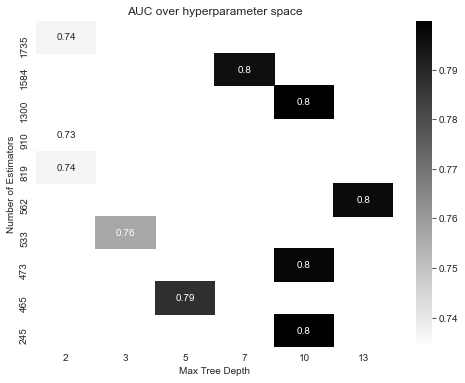

In [11]:
rf_res = pd.DataFrame(rf_rand.cv_results_)
rf_res.sort_values('mean_test_score',axis=0, ascending=False)
rf_piv = rf_res.sort_values('param_randomforestclassifier__max_depth').pivot(
    index='param_randomforestclassifier__n_estimators',columns='param_randomforestclassifier__max_depth', values ='mean_test_score' )
param_heat(rf_piv,'Max Tree Depth','Number of Estimators')

In [12]:
rf_rand.best_score_

0.799849706751754

In [13]:
from sklearn.metrics import roc_curve

def roc_plot(e,x,y):
    """e is estimator, x is data and y is true value"""

    #predicting from model
    y_pred = e.predict_proba(x)[:,1]

    #finding curve
    fpr, tpr, t = roc_curve(y, y_pred)
    ax = plt.figure(figsize=(8,6))
    sns.lineplot(x=fpr,y=tpr)
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Compute Receiver Operating Characteristic Curve')
    return pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':t})

    


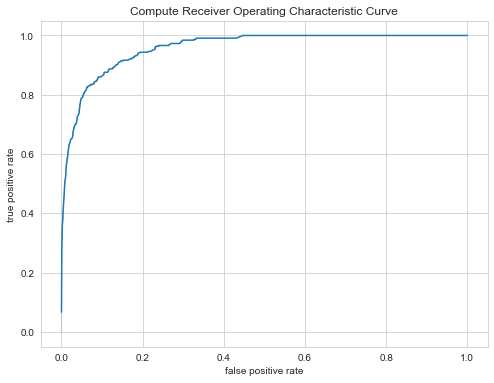

In [14]:
est = rf_rand.best_estimator_
c = roc_plot(est, X_train, y_train)

***Comparing to test set***

In [15]:
from sklearn.metrics import roc_auc_score


def test_comp(e):
    #predicting probability from test set
    y_pred = e.predict_proba(X_test)[:,1]
    
    
    r = np.round(roc_auc_score(y_test,y_pred),3)
    
    print('Evaluating the classifier on the test set, area under the roc curve is: ' +  
           '{}'.format(r))

test_comp(rf_rand.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.821


### 2.3 Random Forest Conclusions
<a id='rfc_conc'></a>
The Random Forest Classifier performs moderately well with an auc of 0.79 on the training set and 0.817 on the test set. From the broad random serach, the optimal hyperparameters are a max depth of 10 and 1300 estimators.

### 3 Logistic Regression
<a id='log'></a>


In [16]:
from sklearn.linear_model import LogisticRegression

### 3.1 Building and Fitting Pipeline
<a id='log_pipe'></a>

In [17]:
pipe_lr = make_pipeline( 
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

params = {'logisticregression__C': np.logspace(-4,2)}

#starting with few iterations, and narrowing the ranges afterwards
lr = RandomizedSearchCV(pipe_lr,param_distributions=params,cv=5, n_jobs=-1, verbose =10, 
                                 scoring = 'roc_auc',n_iter=20,random_state = 42)


In [18]:
lr.fit(X,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0337s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1775s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=1000))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'logisticregression__C': array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-0...
       2.68269580e-01, 3.55648031e-01, 4.71486636e-01, 6.25055193e-01,
       8.28642773e-01, 1.09854114e+00, 1.45634848e+00, 1.93069773e+00,
       2.55954792e+00, 3.39322177e+00, 4.49843267e+00, 5.96362332e+00,
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02])},
                   random

In [19]:
lr.best_params_

{'logisticregression__C': 0.00023299518105153718}

### 3.2 Assessing Performance
<a id='log_perf'></a>


In [20]:
lr.best_score_

0.5247265602664899

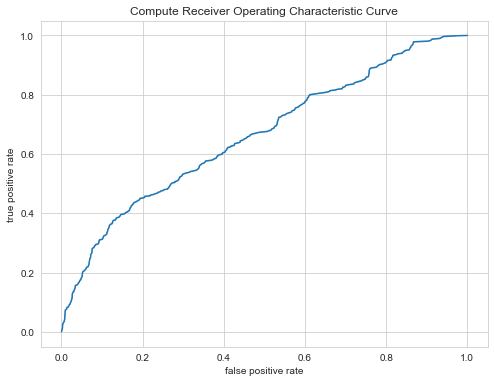

In [21]:
c = roc_plot(lr.best_estimator_,X_train,y_train)

***Evaluating with test set***

In [22]:
test_comp(lr.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.632


### 3.3 Logistic Regression Conclusions
<a id='log_conc'></a>

The logistic regression results were considerably worse on the training and test sets.

### 4 KNN
<a id='knn'></a>

In [23]:
from sklearn.neighbors import KNeighborsClassifier

### 4.1 Building and Fitting Pipeline
<a id='knn_pipe'></a>

In [24]:
pipe_knn = make_pipeline( 
    StandardScaler(),
    KNeighborsClassifier(weights='distance')
)

params = {'kneighborsclassifier__n_neighbors': np.arange(1,201)}
    

#starting with few iterations, and narrowing the ranges afterwards
knn = RandomizedSearchCV(pipe_knn,param_distributions=params,cv=5, n_jobs=-1, verbose =10, 
                                 scoring = 'roc_auc',n_iter=200,random_state = 42)

knn.fit(X_train,y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1239s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 314 tas

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('kneighborsclassifier',
                                              KNeighborsClassifier(weights='distance'))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'kneighborsclassifier__n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,...
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 

In [25]:
knn.best_params_

{'kneighborsclassifier__n_neighbors': 72}

In [26]:
knn_res = pd.DataFrame(knn.cv_results_)

In [27]:
knn_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.064102,0.002776,0.057480,0.005756,1,{'kneighborsclassifier__n_neighbors': 1},0.575248,0.579139,0.588176,0.564483,0.580602,0.577529,0.007756,200
1,0.082714,0.014322,0.074333,0.008347,2,{'kneighborsclassifier__n_neighbors': 2},0.630043,0.655077,0.626930,0.611922,0.649765,0.634747,0.015767,199
2,0.085250,0.009449,0.081529,0.010160,3,{'kneighborsclassifier__n_neighbors': 3},0.664783,0.676486,0.679348,0.626486,0.668235,0.663068,0.019042,198
3,0.092384,0.006438,0.088865,0.003623,4,{'kneighborsclassifier__n_neighbors': 4},0.667958,0.703631,0.686897,0.646696,0.687436,0.678523,0.019517,197
4,0.095164,0.004663,0.094916,0.004026,5,{'kneighborsclassifier__n_neighbors': 5},0.689258,0.718604,0.700370,0.671239,0.700566,0.696007,0.015553,196


<AxesSubplot:title={'center':'AUC over hyperparameter space'}, xlabel='Number of neighbors', ylabel='Mean AUC'>

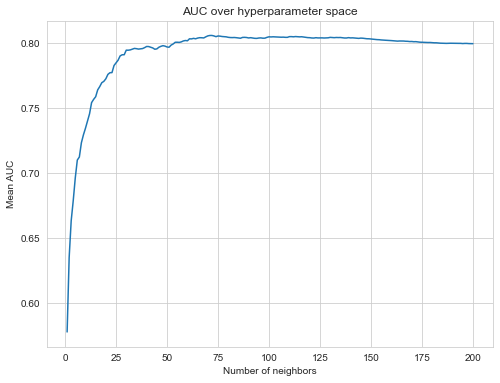

In [28]:
ax = plt.figure(figsize=(8,6))
plt.xlabel('Number of neighbors')
plt.ylabel('Mean AUC')
plt.title('AUC over hyperparameter space')
sns.lineplot(data=knn_res,x='param_kneighborsclassifier__n_neighbors',y='mean_test_score')

### 4.2 Assessing Performance
<a id='knn_perf'></a>

In [29]:
knn.best_score_

0.8055049564196992

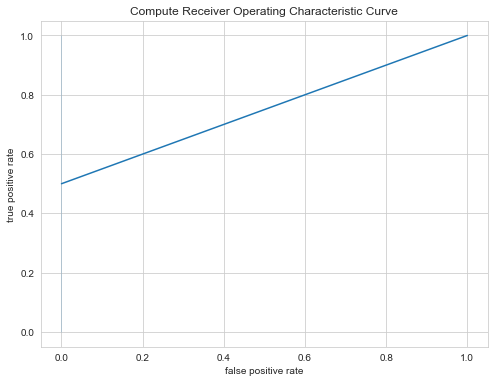

In [30]:
c = roc_plot(knn.best_estimator_,X_train,y_train)

In [31]:
test_comp(knn.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.81


### 4.3 KNN Conclusions
<a id='knn_conc'></a>

The KNN classifier performed about as well as the Random Forest Classifier with an AUC of 0.805. The optimal number of estimators was found to be 72 in the broad random search

### 5 SVC
<a id='svc'></a>


In [32]:
from sklearn.svm import SVC

### 5.1 Building and Fitting Pipeline
<a id='svc_pipe'></a>

In [33]:
pipe_svc = make_pipeline( 
    StandardScaler(),
    SVC(probability=True)
)

params = {'svc__C': np.logspace(-4,1)}
    

#starting with few iterations, and narrowing the ranges afterwards
svc = RandomizedSearchCV(pipe_svc,param_distributions=params,cv=5, n_jobs=-1, verbose =10, 
                                 scoring = 'roc_auc',n_iter=5,random_state = 42)

svc.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    8.5s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   11.3s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   13.2s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   13.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.7s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC(probability=True))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'svc__C': array([1.00000000e-04, 1.26485522e-04, 1.59985872e-04, 2.02358965e-04,
       2.55954792e-04, 3.23745754e-04, 4.09491506e-04, 5.17947468e-04,
       6.55128557e-04, 8.28642773e-04, 1.04811313e-03, 1.32571137e...
       7.19685673e-02, 9.10298178e-02, 1.15139540e-01, 1.45634848e-01,
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 7.54312006e-01, 9.54095476e-01,
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01])},
                   random_state=42, scoring='roc_auc', verbose=10)

In [34]:
svc.best_params_

{'svc__C': 0.9540954763499944}

### 5.2 Assessing Performance
<a id='svc_perf'></a>

In [35]:
svc.best_score_

0.6552479808770845

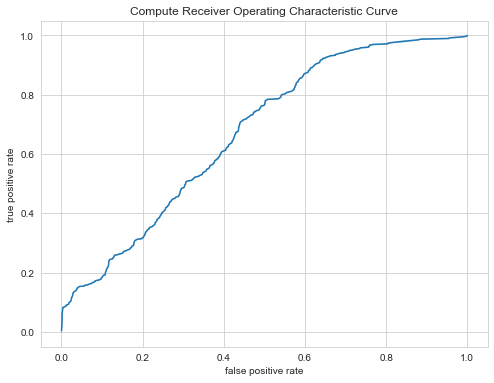

In [36]:
c = roc_plot(svc.best_estimator_,X_train,y_train)

***Evaluating with test set***

In [37]:
test_comp(svc.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.588


### 5.3 SVC Conclusions
<a id='svc_conc'></a>

SVC clearly performs worse than RF or KNN

## 6 Classifier Choice: Random Forest
<a id='rf'></a>

Random Forest and KNN had comperable performance, but the RF classifier has greaterer transparency, feature importance, and the ability to perform a SHAP analysis. For these reasons, and the slight performance advantage, I use the Random Forest classifier.

In [38]:
def roc_plot_comp(e,e2,x,y):
    """e is estimator, x is data and y is true value"""

    #predicting from model
    y_pred = e.predict_proba(x)[:,1];
    y_pred2 = e2.predict_proba(x)[:,1];

    #finding curve
    fpr, tpr, t = roc_curve(y, y_pred);
    fpr2, tpr2, t2 = roc_curve(y, y_pred2);
    ax = plt.figure(figsize=(8,6))
    sns.lineplot(x=fpr,y=tpr,color='b',legend = 'brief')
    sns.lineplot(x=fpr2,y=tpr2,color='r',legend = 'brief')
    plt.legend(['RF','KNN'])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Compute Receiver Operating Characteristic Curve')


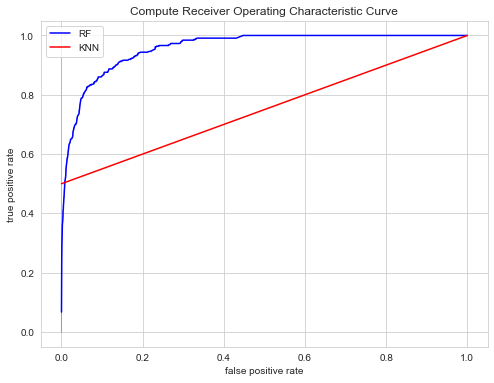

In [39]:
roc_plot_comp(est,knn.best_estimator_,X_train,y_train)

### 6.1 Building and Fitting Pipeline
<a id='rf_pipe'></a>

In [40]:
from sklearn.model_selection import GridSearchCV

pipe_rf = make_pipeline( 
    StandardScaler(), 
    RandomForestClassifier()
)

params = {'randomforestclassifier__n_estimators': np.arange(750,2000,50),
          'randomforestclassifier__max_depth' :  np.arange(6,11)}

rf = GridSearchCV(pipe,param_grid=params,cv=5, n_jobs=-1, scoring = 'roc_auc',verbose=10)

rf.fit(X_train,y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': array([ 6,  7,  8,  9, 10]),
                         'randomforestclassifier__n_estimators': array([ 750,  800,  850,  900,  950, 1000, 1050, 1100, 1150, 1200, 1250,
       1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800,
       1850, 1900, 1950])},
             scoring='roc_auc', verbose=10)

In [41]:
# pipe_rf = make_pipeline( 
#     StandardScaler(), 
#     RandomForestClassifier()
# )

# params = {'randomforestclassifier__n_estimators': np.arange(1200,1250,50),
#           'randomforestclassifier__max_depth' :  np.arange(9,10)}

# rf = GridSearchCV(pipe,param_grid=params,cv=5, n_jobs=-1, scoring = 'roc_auc',verbose=10)

# rf.fit(X_train,y_train)

In [42]:
rf.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 1400}

### 6.2 Assessing Performance
<a id='rf_perf'></a>

In [43]:
rf.best_score_

0.8011832649343562

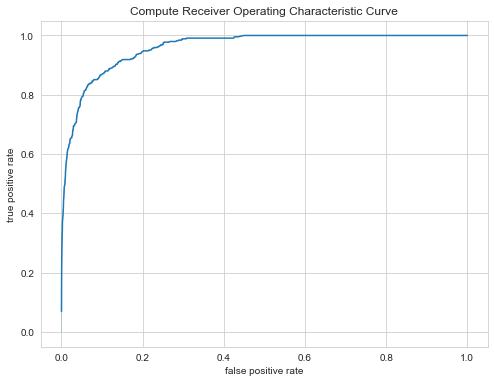

In [44]:
c = roc_plot(rf.best_estimator_,X_train,y_train)

In [45]:
test_comp(rf.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.819


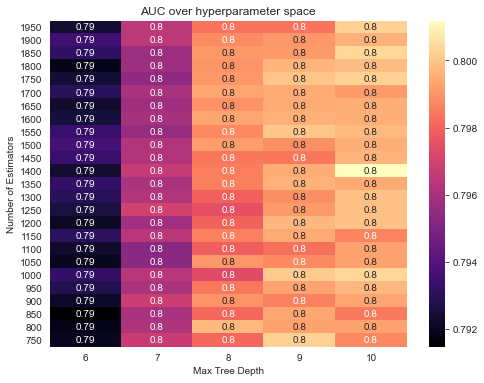

In [46]:
rf_search = pd.DataFrame(rf.cv_results_)
rf_search.sort_values('mean_test_score',axis=0, ascending=False)
rf_piv_result = rf_search.sort_values('param_randomforestclassifier__max_depth').pivot(
    index='param_randomforestclassifier__n_estimators',columns='param_randomforestclassifier__max_depth', values ='mean_test_score' )
param_heat(rf_piv_result,'Max Tree Depth','Number of Estimators',c='magma')

***Precision and Recall***

In [47]:
df_t = c[c.tpr > 0.9].sort_values('threshold',ascending=False)

thresh = df_t.iloc[0,2]

In [48]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def test_comp_recall(e):
    #predicting probability from test set
    y_pred = e.predict(X_test)
    #deciding membership

    r = np.round(recall_score(y_test,y_pred),3)
    p = np.round(precision_score(y_test,y_pred),3)
    print('Evaluating the classifier on the test set, the recall is: ' +  
          '{}, and the precision is: {}'.format(r,p))


from sklearn.metrics import precision_recall_curve

def pr_curve(e,x,y):
    """e is estimator, x is data and y is true value"""

    #predicting from model
    y_pred_rf = e.predict_proba(x)

    #finding curve
    p, r, t = precision_recall_curve(y.to_numpy(),y_pred_rf[:,1])
    ax = plt.figure(figsize=(8,6))
    sns.lineplot(x=p,y=r)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision & Recall curve')
    return pd.DataFrame({'precision':p[:-1],'recall':r[:-1],'threshold':t})

    


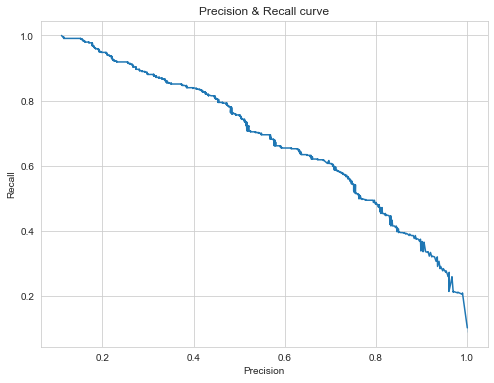

In [49]:
c = pr_curve(rf.best_estimator_,X_train,y_train)

Text(34.0, 0.5, 'True')

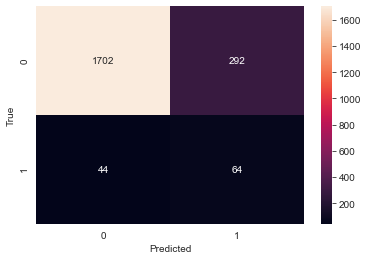

In [50]:
from sklearn.metrics import confusion_matrix

clf = rf_rand.best_estimator_
y_pred = clf.predict_proba(X_test)[:,1]
y_pred = (y_pred >= thresh).astype('int')

sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

### 6.3 Analysis of Features
<a id='rf_feat'></a>

In [51]:
r = rf.best_estimator_
imp = r.steps[1][1].feature_importances_

<AxesSubplot:xlabel='importance', ylabel='feature'>

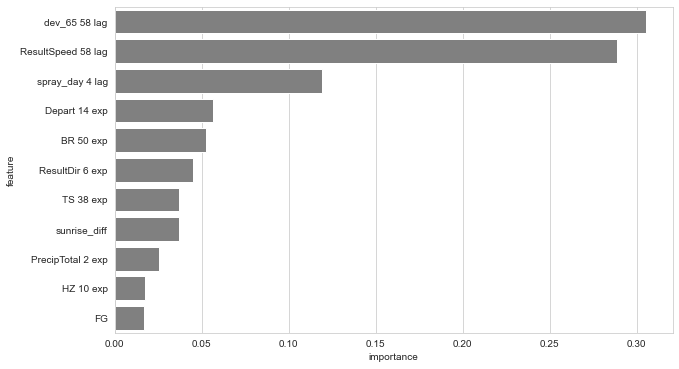

In [52]:
ax = plt.figure(figsize=(10,6))

i = pd.DataFrame({'feature':X_test.columns,'importance':imp}).sort_values('importance',ascending=False)

sns.barplot(data=i,y='feature',x='importance',orient='h',color='gray')

In [53]:
import shap

model = rf.best_estimator_[1]

# compute SHAP values
explainer = shap.TreeExplainer(model, X_train)
shap_values = explainer.shap_values(X_train)

100%|===================| 16791/16808 [13:38<00:00]        

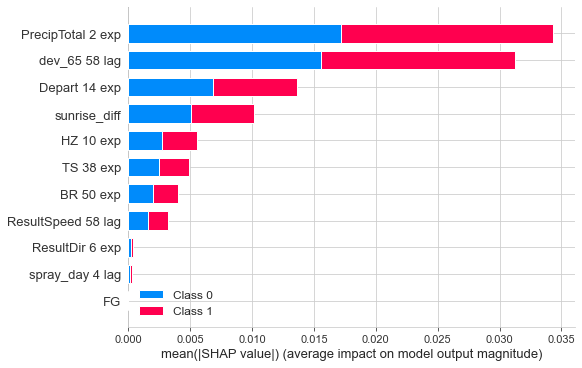

In [54]:
shap.summary_plot(shap_values, X_train)

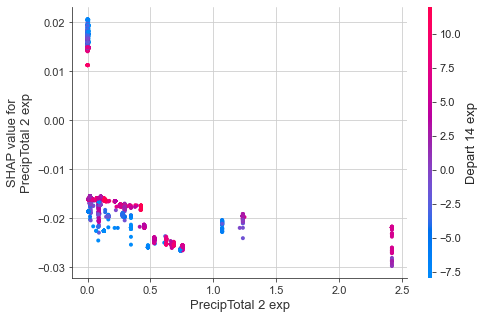

In [55]:
shap.dependence_plot('PrecipTotal 2 exp', shap_values[0], X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


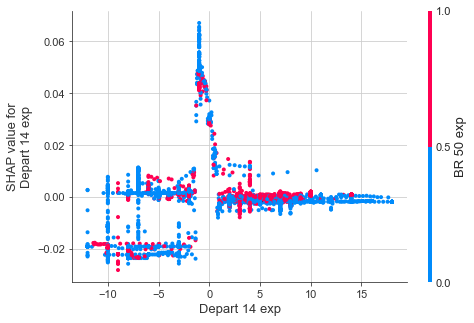

In [56]:
shap.dependence_plot('Depart 14 exp', shap_values[0], X_train)

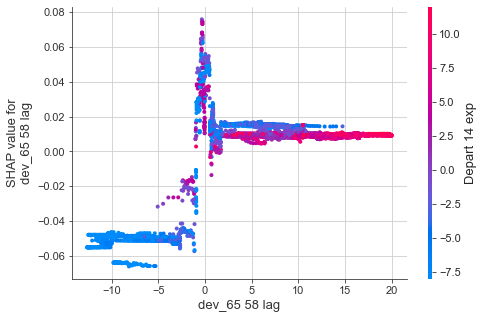

In [57]:
shap.dependence_plot('dev_65 58 lag', shap_values[0], X_train)

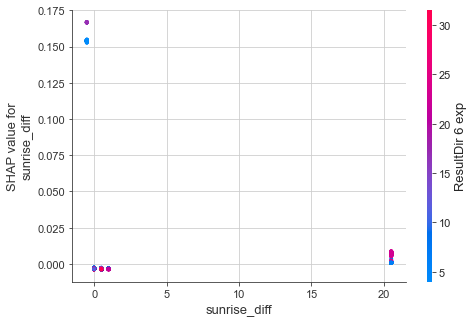

In [58]:
shap.dependence_plot('sunrise_diff', shap_values[0], X_train)

In [59]:
shap_df = pd.DataFrame(shap_values[0])
shap_df2 = pd.DataFrame(shap_values[1])
(np.abs(shap_df) + np.abs(shap_df2)).mean().sort_values(ascending=False)
sun = shap_df[5]
sun_ind = list(sun[sun>0.125].index)
outliers = X.loc[sun_ind]
outliers.describe() - X.describe()

,spray_day 4 lag,Depart 14 exp,PrecipTotal 2 exp,ResultSpeed 58 lag,ResultDir 6 exp,sunrise_diff,dev_65 58 lag,BR 50 exp,HZ 10 exp,TS 38 exp,FG
count,-10414.000000,-10414.000000,-1.041400e+04,-10414.000000,-10414.000000,-10414.000000,-10414.000000,-10414.000000,-10414.000000,-10414.000000,-10414.000000
mean,-0.005711,-1.431686,-2.579396e-02,0.536929,-0.612434,0.043678,-1.740750,-0.057132,-0.039767,0.017947,-0.012136
std,-0.050589,0.783843,-7.716761e-02,0.202831,-0.201487,0.123933,1.223964,-0.027499,-0.061476,0.041015,-0.076950
min,0.000000,0.000000,0.000000e+00,1.286965,1.000000,0.500000,0.542421,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-2.464286,-1.977585e-16,0.284237,0.500000,0.000000,-3.160388,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-1.928571,5.000000e-03,0.442637,-0.583333,0.000000,-1.227925,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,3.500000e-02,1.172948,-1.375000,0.000000,-0.324225,0.000000,0.000000,-0.026316,0.000000
max,-0.870403,0.000000,-1.185000e+00,-0.308027,0.000000,0.000000,-0.259738,0.000000,0.000000,0.000000,-0.500000


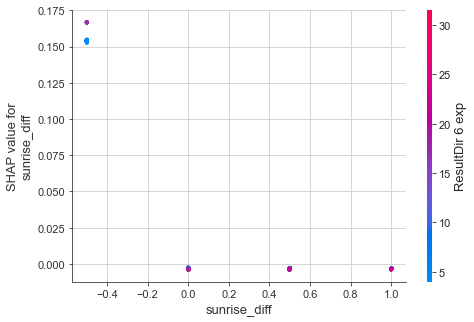

In [60]:
mask = X_train.sunrise_diff < 10
shaps = shap_values[0]

shap.dependence_plot('sunrise_diff', shaps[mask], X_train.loc[mask,:])

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


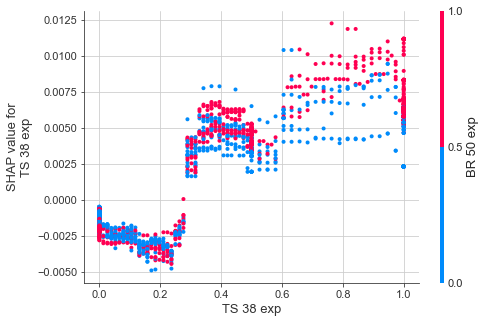

In [61]:
shap.dependence_plot('TS 38 exp', shap_values[0], X_train)

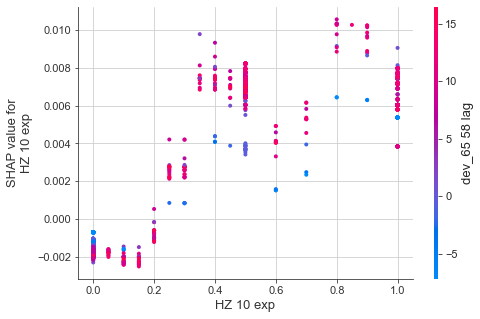

In [62]:
shap.dependence_plot('HZ 10 exp', shap_values[0], X_train)

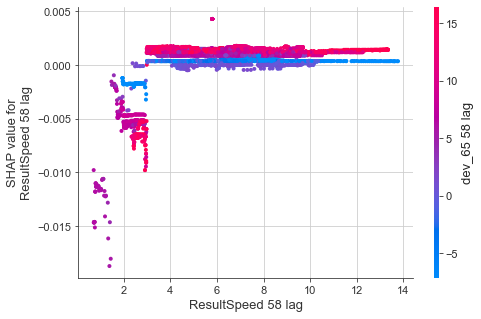

In [63]:
shap.dependence_plot('ResultSpeed 58 lag', shap_values[0], X_train)

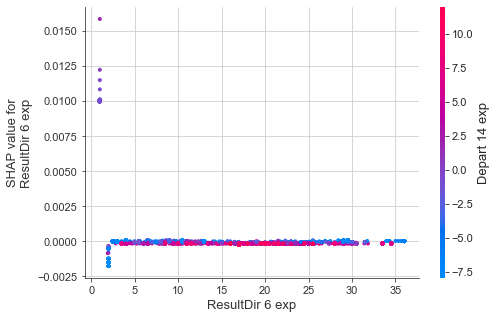

In [64]:
shap.dependence_plot('ResultDir 6 exp', shap_values[0], X_train)

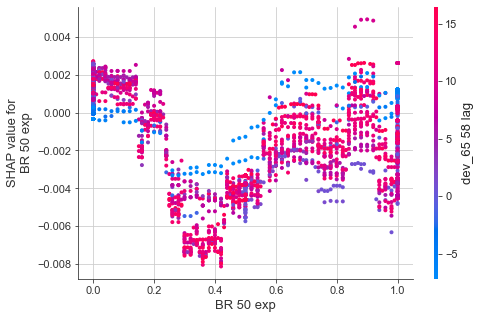

In [65]:
shap.dependence_plot('BR 50 exp', shap_values[0], X_train)

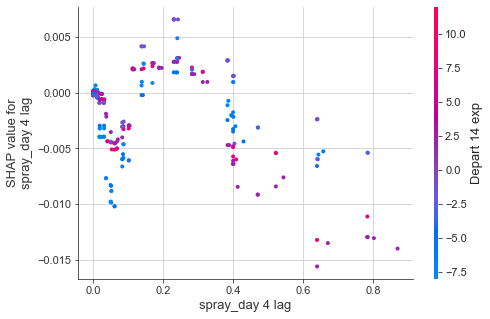

In [66]:
shap.dependence_plot('spray_day 4 lag', shap_values[0], X_train)

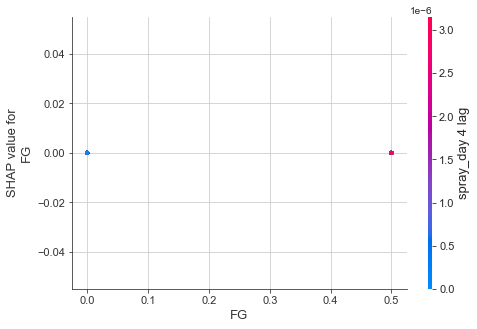

In [67]:
shap.dependence_plot('FG', shap_values[0], X_train)

### 6.4 Conclusions
<a id='rf_conc'></a>

***ROC AUC: 0.816***

***Hyperparameters:***

max depth: 9

estimators: 1050 


The Random Forest Classifier performs moderately well, achieving an ROC AUC of approximately 0.80. The SHAP analysis reveals interesting importances and relationships. 

Sunrise_diff. The dependence plot reveals that when the sunrise occurs later in the day, it contributes negatively to the expectation of WNV. This is the only directly seasonal or static feature in the feature set. It indicates that after the summer solstice, which occurs around mid-June every year, we expect to begin seeing WNV less and less. Mosquito populations rise and fall with the seasons, on a somewhat predictable schedule, and the fact that the sunrise difference has the greatest SHAP magnitude shows the strength of seasonal prediction 

Dev_65 58 lag is a daily measure of average temperature deviance from 65 F, the base temperature, averaged uniformly over 58 days. The metric is a general indicator of how much heating and cooling will occur in a city on a given day. The dependence plot reveals an interesting trend — there are negative contributions at both tails, with a strong spike near the origin. When temperatures are above 65 F, we expect to see fewer WNV occurrences; when considerably lower than 65 F, we have the same expectation. Only between -2 and 0 do we see a positive contribution.

HZ 10 exp is a 10-span exponentially weighted moving average of haze occurrences. Again, the relationship does not appear monotonic, with a peak between 0.4 and 0.6. The SHAP contribution is entirely negative, but generally less negative with higher occurrences of haze. We expect to see marginally more WNV as we see more haze.

Depart 14 exp is a 14-span exponentially weighted moving average of the departure from historical temperature averages on a given day. As dev_65 indicates, we see here that slightly cooler temperatures are when we expect to see the most WNV.

PrecipTotal 2 exp is a 2-span exponentially weighted moving average of the daily precipitation. Here, there is a clear negative trend. When there is more precipitation within two days, we expect to see less WNV. This is a surprising result, as it’s well known that stagnant water is necessary for mosquito populations. It’s possible that the short timescale hides this relationship.

TS 38 exp is a 38-span exponentially weighted average of thunderstorm occurrences. Here, as opposed to with precipitation, we see that more thunderstorms are clearly related to more WNV sightings. At a longer time-span, this confirms the relationship of stagnant water to mosquito populations. 